## Forced photometry plot
Started Oct 18, Last edit: Nov 4th

/Users/shemmati/Dropbox/kinematic_lensing/disks/Blending/galblend.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gals =torch.tensor(gals, device="cpu").float()
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/function

     bad covariance matrix
     bad covariance matrix
     singular covariance
    pars at singular:   -0.276   -0.0766   -0.0291     0.999       4.1    0.0213 
     bad covariance matrix
     singular covariance
    pars at singular:    0.304      0.83    0.0219         1      7.15   0.00195 
     bad covariance matrix
     bad covariance matrix
finished making Observations for 5000 observations.
     Number of calls to function has reached maxfev = 4500.
     Number of calls to function has reached maxfev = 4500.
     Number of calls to function has reached maxfev = 4500.
     singular covariance
    pars at singular:      nan       nan       nan       nan       nan       nan       nan       nan       nan       nan       nan       nan       nan       nan 
     Number of calls to function has reached maxfev = 4500.


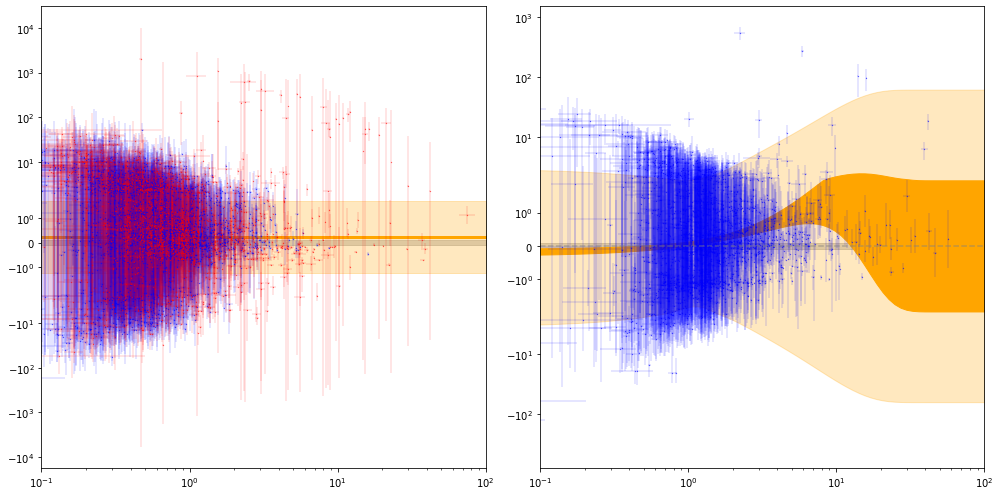

In [15]:
%run deblend_sim.py

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

%matplotlib inline


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(ax,xdata, ydata, nbins_x, nbins_y, color='#bf1d7e',alphaval=1.0, **contour_kwargs):
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1)) 
    pdf = (H*(x_bin_sizes*y_bin_sizes))
 
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    
    levels = [one_sigma,two_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    contour = ax.contour(X, Y, Z, levels=levels,linewidths=2,colors=color,alpha=alphaval)
    return contour

def flux2mag(f):
    m=np.zeros_like(f)
    for i in range(len(f)):
        if f[i]>0:
            m[i]=-2.5*np.log10(f[i])+23.9
        else:
            m[i]=-99.0
    return m

In [26]:
a = np.genfromtxt('blending_results.txt')

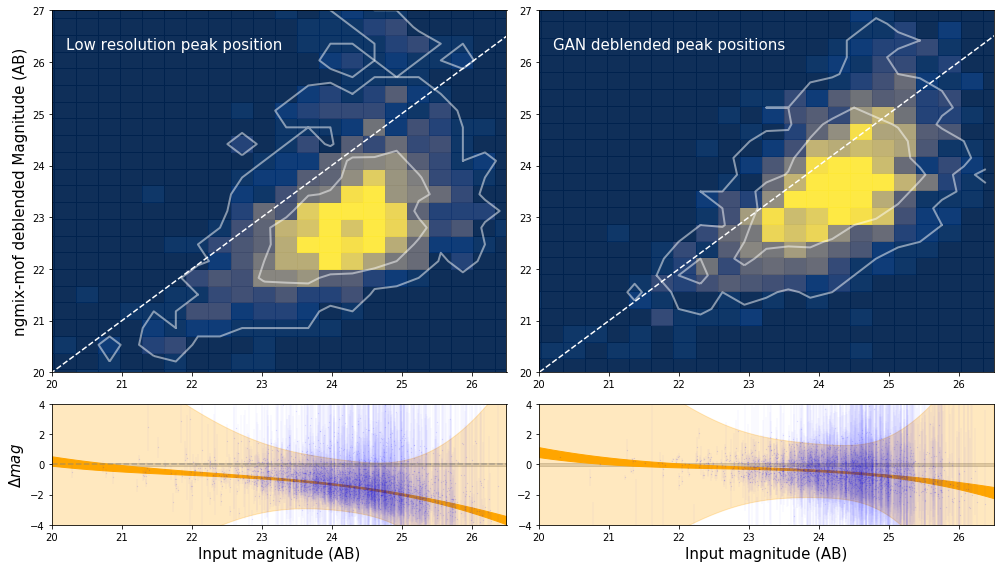

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def get_gp(x,y,yerr,min_calib_error = 0.05, sys_add_error = 1.):
    X  =  np.atleast_2d(x).T
    Y  = y
    dy = np.sqrt(yerr**2 + (x*min_calib_error)**2 + sys_add_error**2)
    kernel =   C(10.0, (1e-4, 1e4)) * RBF(1000, (1e1, 1e7))
    gp = GaussianProcessRegressor(kernel=kernel, alpha= dy ** 2,n_restarts_optimizer=10)
    gp.fit(X,Y)
    return gp

# 0-Input_flux1 1-input_flux2 2-input_chi2per1 3-input_chi2per2 4-input_flux1_err 5-input_flux2_err
# 6-hires_deblended_flux1  7-hires_deblended_flux2  8-hires_deblended_flux1_err  9-hires_deblended_flux2_err
# 10-lores_deblended_flux1  11-lores_deblended_flux2   12-lores_deblended_chi2per   13-lores_deblended_flux1_err
# 14-lores_deblended_flux2_err  15-lores_blended_flux   16-lores_blended_chi2per   17-lores_blended_flux_err

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(14,8),gridspec_kw={'height_ratios': [3, 1]})


bb = 400 

font = {'family' : 'sans-serif',
        'fontname' : 'Times New Roman',
        'size'   : 20}

X,Y = flux2mag(a[:,6]),flux2mag(a[:,15])
ax1.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
ax1.plot([19,27],[19,27],'w--')
ax1.text(20.2,26.25,'Low resolution peak position',color='w',size=15)
#X,Y = flux2mag(a[:,7]),flux2mag(a[:,15])
o=density_contour(ax1,X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
ax1.set_xlim([20,26.5])
ax1.set_ylim([20,27])
#plt.xlabel('Input Magnitude (AB)',size=15)
ax1.set_ylabel('ngmix-mof deblended Magnitude (AB)',size=15)


X,Y = flux2mag(a[:,6]),flux2mag(a[:,10])
ax2.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
ax2.plot([19,27],[19,27],'w--')
X,Y = flux2mag(a[:,7]),flux2mag(a[:,11])
o=density_contour(ax2,X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
ax2.set_xlim([20,26.5])
ax2.set_ylim([20,27])
#plt.xlabel('Input Magnitude (AB)',size=15)
ax2.text(20.2,26.25,'GAN deblended peak positions',color='w',size=15)

chi2_thresh = 10.0

good_input = (a[:,2] <= chi2_thresh) & (a[:,3] <= chi2_thresh)
good_deblended = a[:,12] <= chi2_thresh
good_blended = a[:,16] <= chi2_thresh

keep = (a[:,6]>0)&(a[:,7]>0)&(a[:,10]>0)&(a[:,11]>0)&(a[:,3]<=chi2_thresh)#good_input & good_deblended
x_train = flux2mag(np.hstack([a[keep,6],a[keep,7]]))
x_err_train = 1.083*np.hstack([a[keep,8],a[keep,9]])/np.hstack([a[keep,6],a[keep,7]])
y_train = flux2mag(np.hstack([a[keep,10],a[keep,11]]))
y_err_train = 1.083*np.hstack([a[keep,13],a[keep,14]])/np.hstack([a[keep,10],a[keep,11]])
        
gp_db = get_gp(x_train,y_train-x_train,y_err_train)
Xinterp = np.atleast_2d(np.linspace(20,26.5,100)).T
Yinterp,Yinterp_err = gp_db.predict(Xinterp,return_std=True)
errscl = np.sqrt(np.sum(keep))

ax4.errorbar(x_train,y_train-x_train,yerr=y_err_train,fmt='.',label='good',color='blue',elinewidth=0.2,markersize=0.5,alpha=0.2)
ax4.fill_between(Xinterp.ravel(),np.zeros(Xinterp.size)+0.1,np.zeros(Xinterp.size)-0.1,color='grey',alpha=0.33,zorder=1)
ax4.fill_between(Xinterp.ravel(),(Yinterp-Yinterp_err),(Yinterp+Yinterp_err),color='orange')
ax4.fill_between(Xinterp.ravel(),(Yinterp-Yinterp_err*errscl),(Yinterp+Yinterp_err*errscl),color='orange',alpha=0.25)
ax4.set_ylim([-4,4])
ax4.set_xlim([20,26.5])
ax4.set_xlabel(r'Input magnitude (AB)',size=15)


keep = (a[:,6]>0)&(a[:,7]>0)&(a[:,15]>0)&(a[:,3]<=chi2_thresh)#good_input & good_blended
x_train = flux2mag(np.hstack([a[keep,6],a[keep,7]]))
y_train = flux2mag(np.hstack([a[keep,15],a[keep,15]]))
y_err_train = 1.083*np.hstack([a[keep,17],a[keep,17]])/np.hstack([a[keep,15],a[keep,15]])
xerr = np.sqrt(a[keep,8]**2+a[keep,9]**2)
x_err_train = 1.08*(np.hstack([xerr,xerr])/np.hstack([a[keep,6],a[keep,7]]))
       
gp_bl = get_gp(x_train,y_train-x_train,y_err_train)
Xinterp = np.atleast_2d(np.linspace(20,26.5,100)).T
Yinterp,Yinterp_err = gp_bl.predict(Xinterp,return_std=True)
errscl = np.sqrt(np.sum(keep))

ax3.errorbar(x_train,y_train-x_train,yerr=y_err_train,fmt='.',label='good',color='blue',elinewidth=0.2,markersize=0.5,alpha=0.2)
ax3.axhline(0,color='grey',linestyle='--',alpha=0.5)
ax3.fill_between(Xinterp.ravel(),np.zeros(Xinterp.size)+0.1,np.zeros(Xinterp.size)-0.1,color='grey',alpha=0.33,zorder=1)
ax3.fill_between(Xinterp.ravel(),(Yinterp-Yinterp_err),(Yinterp+Yinterp_err),color='orange')
ax3.fill_between(Xinterp.ravel(),(Yinterp-Yinterp_err*errscl),(Yinterp+Yinterp_err*errscl),color='orange',alpha=0.25)
ax3.set_ylim([-4,4])
ax3.set_xlim([20,26.5])
      
ax3.set_ylabel(r'$\Delta mag$',size=15)
ax3.set_xlabel(r'Input magnitude (AB)',size=15)


plt.tight_layout()

plt.savefig('../plots/gp_mag.png')

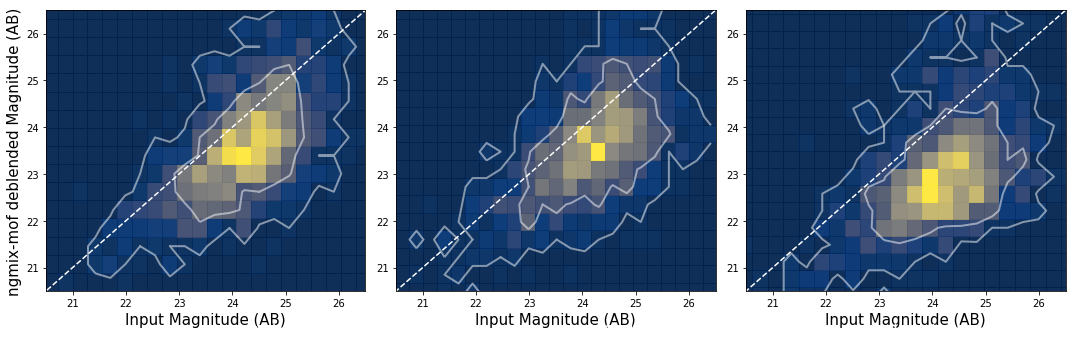

In [20]:
def density_contour(xdata, ydata, nbins_x, nbins_y, color='#bf1d7e',alphaval=1.0, **contour_kwargs):
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1)) 
    pdf = (H*(x_bin_sizes*y_bin_sizes))
 
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    
    levels = [one_sigma,two_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    contour = plt.contour(X, Y, Z, levels=levels,linewidths=2,colors=color,alpha=alphaval)
    return contour
bb = 40

font = {'family' : 'sans-serif',
        'fontname' : 'Times New Roman',
        'size'   : 20}
plt.figure(figsize = (15,5))                              

Xl,Yl = flux2mag(a[:,6]),flux2mag(a[:,10])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.subplot(1,3,1)
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
plt.text(23.5,19.5,'1st Gal',color='w',size=20)

plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.ylabel('ngmix-mof deblended Magnitude (AB)',size=15)


plt.subplot(1,3,2)
Xl,Yl = flux2mag(a[:,7]),flux2mag(a[:,11])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
plt.text(23.5,19.5,'2nd Gal',color='w',size=20)

plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)


plt.subplot(1,3,3)
Xl,Yl = flux2mag(a[:,6]),flux2mag(a[:,15])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
plt.text(23,19.5,'Blended',color='w',size=20)
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
  
plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.tight_layout()
#plt.ylabel('Measured Magnitude (AB)')
plt.savefig('../plots/photometry.png')

<Figure size 1008x432 with 0 Axes>

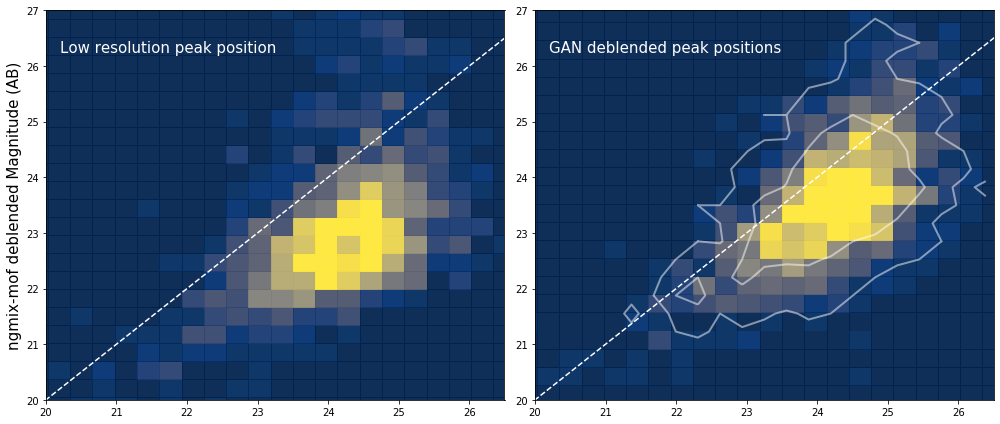

In [21]:
bb = 400 

font = {'family' : 'sans-serif',
        'fontname' : 'Times New Roman',
        'size'   : 20}
plt.figure(figsize = (14,6))                              
X,Y = flux2mag(a[:,6]),flux2mag(a[:,10])
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

ax2.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
ax2.plot([19,27],[19,27],'w--')
X,Y = flux2mag(a[:,7]),flux2mag(a[:,11])
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
ax2.set_xlim([20,26.5])
ax2.set_ylim([20,27])
#plt.xlabel('Input Magnitude (AB)',size=15)
ax2.text(20.2,26.25,'GAN deblended peak positions',color='w',size=15)

X,Y = flux2mag(a[:,6]),flux2mag(a[:,15])
ax1.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
ax1.plot([19,27],[19,27],'w--')
ax1.text(20.2,26.25,'Low resolution peak position',color='w',size=15)
#X,Y = flux2mag(a[:,7]),flux2mag(a[:,15])
#o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
  
ax1.set_xlim([20,26.5])
ax1.set_ylim([20,27])
#plt.xlabel('Input Magnitude (AB)',size=15)
ax1.set_ylabel('ngmix-mof deblended Magnitude (AB)',size=15)

plt.tight_layout()
#plt.ylabel('Measured Magnitude (AB)')
plt.savefig('../plots/photometry.png')

In [22]:
def density_contour(xdata, ydata, nbins_x, nbins_y, color='#bf1d7e',alphaval=1.0,ax=None, **contour_kwargs):
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1)) 
    pdf = (H*(x_bin_sizes*y_bin_sizes))
 
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    
    levels = [one_sigma]#,two_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    contour = plt.contour(X, Y, Z, levels=levels,linewidths=2,colors=color,alpha=alphaval)
    return contour

def runmed(X,Y,total_bins):
    bins = np.linspace(22,26, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = [np.median(Y[idx==k]) for k in range(total_bins)]
    xr=bins-delta/2
    a=[xr,running_median]
    return a

def plot_photcomp(cndmag,hstmag,bb):
    
    X=cndmag[(cndmag!=-99.0)&(hstmag!=-99.0)]
    Y=cndmag[(cndmag!=-99.0)&(hstmag!=-99.0)]-hstmag[(cndmag!=-99.0)&(hstmag!=-99.0)]
    rm=runmed(X,Y,20)
    d=np.median(Y[(X>23.0)&(X<24)])
    font = {'family' : 'sans-serif',
            'fontname' : 'Times New Roman',
            'size'   : 20}
    
    plt.hist2d(X,Y,vmin=0,vmax=30,bins=[bb,bb],cmap='cividis',zorder=1)
    plt.plot(rm[0],rm[1],color='#04b4b0',linewidth=3,zorder=4)
    o=density_contour(X,Y,bb,bb,zorder=3)
    plt.text(20.3,1.7,r'$\rm \Delta =$'+str(round(d,2)),**font)


    plt.plot([14,30],[0,0],'k-')
    plt.xlim([20,26.5])
    plt.ylim([-3,3])

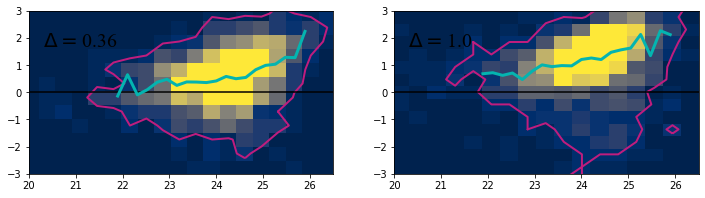

In [23]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
X,Y = flux2mag(a[:,7]),flux2mag(a[:,11])
plot_photcomp(X,Y,30)

plt.subplot(1,2,2)
X,Y = flux2mag(a[:,6]),flux2mag(a[:,15])
plot_photcomp(X,Y,30)
